In [1]:
import colorsys
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from svgpathtools import svg2paths

In [20]:
# ------ plot color wheel ------
def plot_wheel(t_type, fig=plt.figure(), sub=None, all=False):
    # generate random data
    theta = np.linspace(0, 2*np.pi, 360)
    r = np.random.uniform(0.8, 1, 360)

    T, R = np.meshgrid(theta, r)  # create a meshgrid for pcolormesh
    C = T / (2*np.pi)  # create the color values for each meshgrid point

    # plot the polar plot
    if not all:
        ax = fig.add_subplot(111, projection='polar')
    else:
        ax = fig.add_subplot(sub, projection='polar')
    ax.set_axis_off()

    # hue wheel
    ax.pcolormesh(T, R, C, cmap=cm.hsv)

    # gray region
    if t_type == "i":
        a0, a1, b0, b1 = 81 * np.pi / 180, 99 * np.pi / 180, 0, 0
    elif t_type == "V":
        a0, a1, b0, b1 = 43.2 * np.pi / 180, 136.8 * np.pi / 180, 0, 0
    elif t_type == "L":
        a0, a1 = 81 * np.pi / 180, 99 * np.pi / 180
        b0, b1 = 39.6 * np.pi / 180, -39.6 * np.pi / 180
    elif t_type == "I":
        a0, a1 = 81 * np.pi / 180, 99 * np.pi / 180
        b0, b1 = 261 * np.pi / 180, 279 * np.pi / 180
    elif t_type == "T":
        a0, a1, b0, b1 = np.pi/2, -np.pi/2, 0, 0
    elif t_type == "Y":
        a0, a1 = 43.2 * np.pi / 180, 136.8 * np.pi / 180
        b0, b1 = 261 * np.pi / 180, 279 * np.pi / 180
    elif t_type == "X":
        a0, a1 = 43.2 * np.pi / 180, 136.8 * np.pi / 180
        b0, b1 = 223.2 * np.pi / 180, 316.8 * np.pi / 180
    elif t_type == "N":
        a0, a1, b0, b1 = 0, 0, 0, 0
    theta = np.linspace(a0, a1, 100)
    ax.fill_between(theta, 0.8, color='#bdbdbd', edgecolor='none')
    theta = np.linspace(b0, b1, 100)
    ax.fill_between(theta, 0.8, color='#bdbdbd', edgecolor='none')

    # center
    ax.scatter(0, 0, color='black', marker='o', s=50)
    plt.title(t_type)
    if not all: plt.show()

# fig = plt.figure(figsize=(10, 6))
# plot_wheel("i", fig, 241, True)
# plot_wheel("V", fig, 242, True)
# plot_wheel("L", fig, 243, True)
# plot_wheel("I", fig, 244, True)
# plot_wheel("T", fig, 245, True)
# plot_wheel("Y", fig, 246, True)
# plot_wheel("X", fig, 247, True)
# plot_wheel("N", fig, 248, True)
# plt.show()

<Figure size 640x480 with 0 Axes>

In [6]:
# ------ read icon and preprocessing ------
# read svg file
paths, attributes = svg2paths('030-storm-14.svg')
hue = []
hs = []

# extract colors and convert to hsv
for ele in attributes:
    if 'style' in ele:
        hex = ele['style'].split('#')[1].replace(';', '')
        rgb = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))  # hex to rgb
        hsv = colorsys.rgb_to_hsv(rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0)  # rgb to hsv
        if int(hsv[0]*360) == 360: h = 0  # 360 is the same as 0
        else: h = int(hsv[0]*360)
        hue.append(h)
        hs.append([h, hsv[1]])
        
# print(hue)
# print(hs)

# # convert input color to vector with probability
# vec = [1/len(set(hue)) if i in set(hue) else 0 for i in range(360)]
# for i in set(hue):
#     prob = hue.count(i) / len(hue)  # probability of occurrence = times / number of colors
#     vec[i] = prob
# vec = np.array(vec)

In [22]:
# ------ calculate the distance between input colors and templates ------
# ------ only use angle diff (w/o probability distribution) ------

# when alpha = 0, the valid region for each template (except N)
templates = dict()  # in order !!!!!!!!
templates["X"] = np.array([0, 93.6, 180, 273.6])
templates["L"] = np.array([0, 79.2, 120.6, 138.6])
templates["Y"] = np.array([0, 93.6, 217.8, 235.8])
templates["I"] = np.array([0, 18, 180, 198])
templates["T"] = np.array([0, 180])
templates["V"] = np.array([0, 93.6])
templates["i"] = np.array([0, 18])


# hue distance between image and template
best = (None, float('inf'))
for t, v in templates.items():
    # single region
    if t in ['i', 'V', 'T']:
        for i in range(360):
            distance = 0
            for h in hue:
                if ((v[0] < v[1] and (h < v[0] or h > v[1])) or\
                    (v[0] > v[1] and (h < v[0] and h > v[1]))):
                    distance += min(abs(h-v[0]), abs(h-v[1]), abs(360-h+v[0]), abs(360-h+v[1]))
            if distance < best[1]: best = (t, distance)
            
    # symmetric
    elif t in ['I', 'X']:
        for i in range(180):
            distance = 0
            for h in hue:
                if ((v[2] < v[3] and ((h < v[0] or h > v[1]) and (h < v[2] or h > v[3]))) or\
                    (v[2] > v[3] and ((h < v[0] or h > v[1]) and (h < v[2] and h > v[3])))):
                    distance += min(abs(h-v[0]), abs(h-v[1]), abs(h-v[2]), abs(h-v[3]),
                                    abs(360-h+v[0]), abs(360-h+v[1]), abs(360-h+v[2]), abs(360-h+v[3]))
            if distance < best[1]: best = (t, distance)
                    
    # double region (L and Y)
    else:
        for i in range(360):
            distance = 0
            for h in hue:
                if (((v[0] < v[1] and v[2] < v[3]) and ((h < v[0] or h > v[1]) and (h < v[2] or h > v[3])))or\
                    ((v[0] > v[1] and v[2] < v[3]) and ((h < v[0] and h > v[1]) and (h < v[2] or h > v[3])))or\
                    ((v[0] < v[1] and v[2] > v[3]) and ((h < v[0] or h > v[1]) and (h < v[2] and h > v[3])))):
                    distance += min(abs(h-v[0]), abs(h-v[1]), abs(h-v[2]), abs(h-v[3]),
                                    abs(360-h+v[0]), abs(360-h+v[1]), abs(360-h+v[2]), abs(360-h+v[3]))
            if distance < best[1]: best = (t, distance)
            
print(hue)
print(best)                

[199, 205, 45, 206, 198]
('X', 0)


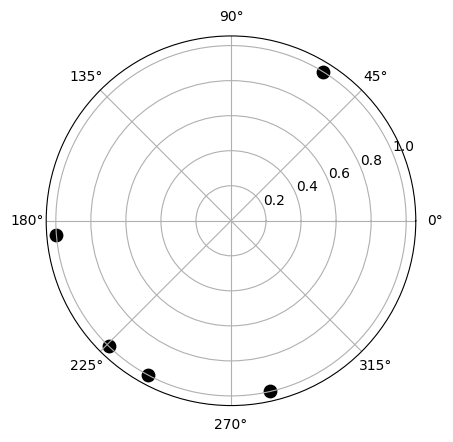

In [5]:
# plot color point on the hue curcle
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
for angle in hue:
    ax.scatter(angle, 1, color='black', s=80, marker='o')
plt.show()